Monthly milk production dataset per cow from Jan '62 to Dec '75

Source : https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
milk = pd.read_csv('./monthly-milk-production-pounds-p.csv', index_col='Month')

In [3]:
milk.head()

,Milk production
Month,
1962-01,589
1962-02,561
1962-03,640
1962-04,656
1962-05,727


In [4]:
milk.index = pd.to_datetime(milk.index)
milk.head()

,Milk production
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


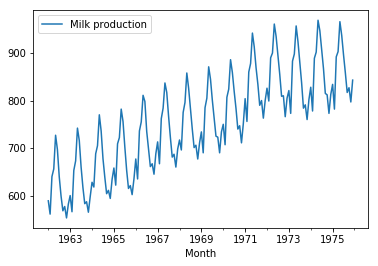

In [5]:
milk.plot()

# train test split 

Here we can not perform a random train test split. we want to give all but last year's data as training set, and keep the last year data as test set. Our network should make prediction on the last year values.

In [6]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
Milk production    168 non-null int64
dtypes: int64(1)
memory usage: 2.6 KB


In [7]:
# 168 rows and 2 columns 
# 156 rows for training and 12 for test

train_data = milk.head(156)
test_data = milk.tail(12)

In [8]:
# data till year 1974
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 156 entries, 1962-01-01 to 1974-12-01
Data columns (total 1 columns):
Milk production    156 non-null int64
dtypes: int64(1)
memory usage: 2.4 KB


In [9]:
# data for year 1975
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 1975-01-01 to 1975-12-01
Data columns (total 1 columns):
Milk production    12 non-null int64
dtypes: int64(1)
memory usage: 192.0 bytes


# scale the data 

Use the sklearn preprocessing to scale the data using MinMaxScaler. 

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()

In [12]:
train_scaled = scaler.fit_transform(train_data)

In [13]:
test_scaled = scaler.fit_transform(test_data)

# get next batch

A function to feed training data in batches. 

In [14]:
def get_next_batch(training_data, batch_size, steps):
    """
    input : data, batch size, time steps per batch
    output : a tuple pf y time series results -- y[:, :-1] and y[:, 1:]
    """
    
    # step 1 : each batch should have same number of steps in it. 
    # so limit the starting point to len(data) - steps
    rand_start = np.random.randint(0, len(training_data)-steps)
    
    # step 2 : index the data from rand_start to rand_start + steps + 1
    # then reshape it to (1, steps+1)
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1, steps+1)
    
    # step 3 : return batches. 

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

# setup rnn model


In [15]:
import tensorflow as tf 

In [16]:
num_inputs = 1
num_time_steps = 12  # 12 months 
num_neurons = 100 
num_outputs = 1
learning_rate = 0.003
num_traing_iterations = 6000
batch_size = 1

In [17]:
# placeholders 
x = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])


In [18]:
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.relu), output_size=num_outputs)

In [19]:
# create a rnn from the cell
outputs, state = tf.nn.dynamic_rnn(cell=cell, inputs=x, dtype=tf.float32)

In [20]:
# loss 
loss = tf.reduce_mean(tf.square(outputs - y))

In [33]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [34]:
train = optimizer.minimize(loss)

In [35]:
init = tf.global_variables_initializer()

In [36]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)

In [37]:
saver = tf.train.Saver()

In [38]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_traing_iterations):
        
        x_batch, y_batch = get_next_batch(training_data=train_scaled, batch_size=batch_size, steps=num_time_steps)
        
        sess.run(train, feed_dict={x:x_batch, y:y_batch})
        
        if iteration%100 == 0:
            mse = loss.eval(feed_dict={x:x_batch, y:y_batch})
            print(iteration, '\t MSE', mse)
    
    # save the model, so that we can directly restore it later for inference
    saver.save(sess, './rnn_cow_milk_production_example')

0 	 MSE 0.073651545
100 	 MSE 0.045660425
200 	 MSE 0.098128766
300 	 MSE 0.062068176
400 	 MSE 0.019846048
500 	 MSE 0.033237558
600 	 MSE 0.015203855
700 	 MSE 0.033378746
800 	 MSE 0.02187532
900 	 MSE 0.015989844
1000 	 MSE 0.015971253
1100 	 MSE 0.013913809
1200 	 MSE 0.01033914
1300 	 MSE 0.0071397237
1400 	 MSE 0.01473773
1500 	 MSE 0.014089639
1600 	 MSE 0.022086956
1700 	 MSE 0.008941687
1800 	 MSE 0.005596965
1900 	 MSE 0.009350129
2000 	 MSE 0.009135445
2100 	 MSE 0.011928689
2200 	 MSE 0.008508604
2300 	 MSE 0.010648422
2400 	 MSE 0.009914298
2500 	 MSE 0.015232558
2600 	 MSE 0.009148412
2700 	 MSE 0.0071668946
2800 	 MSE 0.007820242
2900 	 MSE 0.008805624
3000 	 MSE 0.0061196373
3100 	 MSE 0.0077196048
3200 	 MSE 0.007403847
3300 	 MSE 0.0107666105
3400 	 MSE 0.0090101
3500 	 MSE 0.007247796
3600 	 MSE 0.006309046
3700 	 MSE 0.0072573754
3800 	 MSE 0.005402552
3900 	 MSE 0.00967702
4000 	 MSE 0.0068419925
4100 	 MSE 0.0054398044
4200 	 MSE 0.008836371
4300 	 MSE 0.00723856

In [39]:
with tf.Session() as sess:

    saver.restore(sess, './rnn_cow_milk_production_example')
    
    train_seed = list(train_scaled[-num_time_steps:])
    
    for iteration in range(num_time_steps):
        
        x_batch = np.array(train_seed[-num_time_steps:]).reshape(-1, num_time_steps, 1)
        
        y_pred = sess.run(outputs, feed_dict={x:x_batch})

        train_seed.append(y_pred[0,-1])
        
        

INFO:tensorflow:Restoring parameters from ./rnn_cow_milk_production_example


In [40]:
train_seed
# y_pred

[array([0.66105769]),
 array([0.54086538]),
 array([0.80769231]),
 array([0.83894231]),
 array([1.]),
 array([0.94711538]),
 array([0.85336538]),
 array([0.75480769]),
 array([0.62980769]),
 array([0.62259615]),
 array([0.52884615]),
 array([0.625]),
 array([0.61987627], dtype=float32),
 array([0.65146434], dtype=float32),
 array([0.73299634], dtype=float32),
 array([0.86247313], dtype=float32),
 array([0.97837055], dtype=float32),
 array([1.0073524], dtype=float32),
 array([0.88058543], dtype=float32),
 array([0.75895274], dtype=float32),
 array([0.64140165], dtype=float32),
 array([0.5883343], dtype=float32),
 array([0.5556835], dtype=float32),
 array([0.5910305], dtype=float32)]

In [41]:
 '''
 This is the data of interest.
 
 array([0.6445907], dtype=float32),
 array([0.64913553], dtype=float32),
 array([0.6948407], dtype=float32),
 array([0.80383533], dtype=float32),
 array([0.8872159], dtype=float32),
 array([0.98493], dtype=float32),
 array([0.9105064], dtype=float32),
 array([0.8090516], dtype=float32),
 array([0.7002785], dtype=float32),
 array([0.58972025], dtype=float32),
 array([0.56556237], dtype=float32),
 array([0.54153305], dtype=float32)] 
 '''
# This data is still in transformed form, due to sklearn scaler
# inverse the transform to get actual numbers

results = scaler.inverse_transform(np.array(train_seed[-num_time_steps:])).reshape(12, 1)
results

array([[896.05725],
       [901.86945],
       [916.87134],
       [940.695  ],
       [962.0202 ],
       [967.35284],
       [944.0278 ],
       [921.6473 ],
       [900.01794],
       [890.2535 ],
       [884.2458 ],
       [890.74963]], dtype=float32)

In [42]:
# create a test_set and set the predictions to the generated result.

test_data['Generated'] = results

/home/student/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
test_data

,Milk production,Generated
Month,,
1975-01-01,834,896.057251
1975-02-01,782,901.869446
1975-03-01,892,916.871338
1975-04-01,903,940.695007
1975-05-01,966,962.020203
1975-06-01,937,967.352844
1975-07-01,896,944.027771
1975-08-01,858,921.647278
1975-09-01,817,900.017944


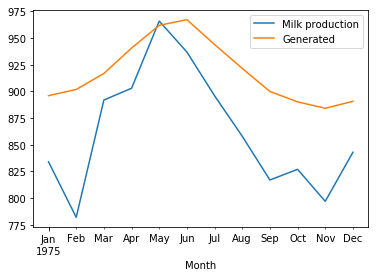

In [44]:
# plot the data 
test_data.plot()

# note: the model is trained to predict only the next 1 value and its a bit unfair to ask it to give predictions for next 12 months 
